In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [32]:
def AR(phi, n):
    Lx = []
    x0 = 0
    for t in range(n):
        xt = phi*x0+np.random.normal(0,1)
        Lx.append(xt)
        x0 = xt
    return Lx

In [90]:
#초기값에 영향을 안받기 위해서 100을 추가해서 앞에꺼를 제거함
def AR1(phi0, phi1, n):
    L = []
    x0 = 0
    for t in range(100+n):
        xt = phi0+phi1*x0+np.random.normal(0, 1)
        L.append(xt)
        x0 = xt
    return L[100:]

In [69]:
def ARMA_22(phi0, phi1, phi2, th1, th2, ss, n):
    L = []
    w = np.random.normal(0, ss**0.5, n+2) #w[0], w[1],...,w[n+1]
    x00, x0 = 0, 0
    for t in range(2, n+2): #t=2,3,...,n+1 모두 n개
        xt = phi0 + phi1*x0 + phi2*x00 + w[t] +th1*w[t-1] + th2*w[t-2]
        L.append(xt)
        x00 = x0
        x0 = xt
    plt.plot(L)
    plt.show()
    return L

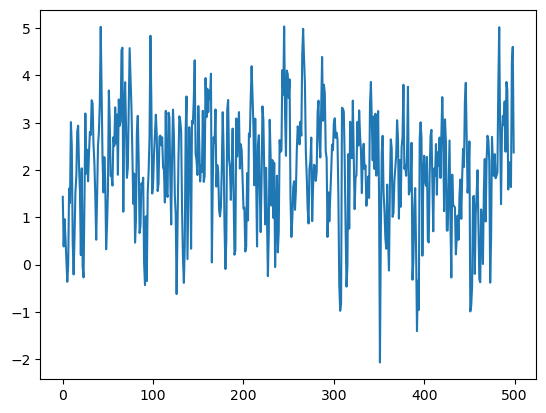

In [70]:
ar_1=AR1(3, 0.6,500)
ar_2=ARMA_22(1, 0.7, -0.2, 0, 0, 1, 500)

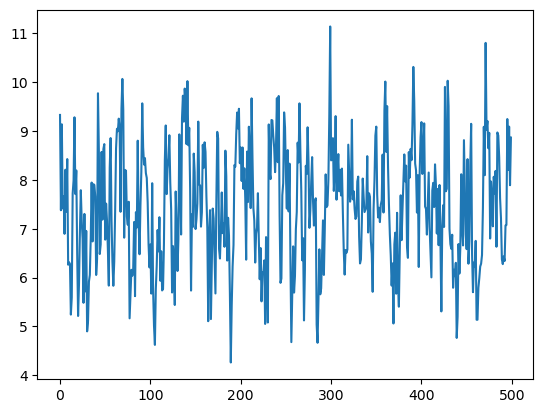

In [71]:
plt.plot(ar_1)
plt.show()

In [48]:
def OLSE_AR_1(D): # D=data
    n = len(D)
    X = np.array(D) - np.mean(D)
    L_num, L_den = [], []
    for t in range(1, n):
        L_num.append(X[t]*X[t-1])
        L_den.append(X[t-1]**2)
    olse = sum(L_num) / sum(L_den) # for phi = pih_1
    hat_phi0 = np.mean(D)*(1-olse) # mu = phi0 / (1-phi_1)
    hat_phi1 = olse
    return hat_phi0, hat_phi1

In [49]:
OLSE_AR_1(ar_1)

(-0.00245100763050033, 0.3374266284200753)

In [50]:
def ACF(D):
    x = D
    n = len(D)
    mu = np.mean(D)
    L = []
    for h in range(21): #h=0,1,2,...,20
        Lh = []
        for t in range(0, n-h):
            ac = (x[t+h] - mu)*(x[t]-mu)
            Lh.append(ac)
        autocov_h = sum(Lh)/n
        L.append(autocov_h)
    AutoCov = np.array(L)
    Sacf = AutoCov/AutoCov[0]
    plt.plot(Sacf, marker = 'o')
    y = [0 for t in range(21)]
    plt.plot(y, 'black')
    plt.show()
    return Sacf

In [51]:
def YW_AR_1(D):
    n = len(D)
    X = np.array(D) - np.mean(D)
    sacf = ACF(D)
#     sacf = sm.tsa.acf()
    hat_phi1 = sacf[1]
    hat_phi0 = np.mean(D)*(1-hat_phi1)
    return hat_phi0, hat_phi1

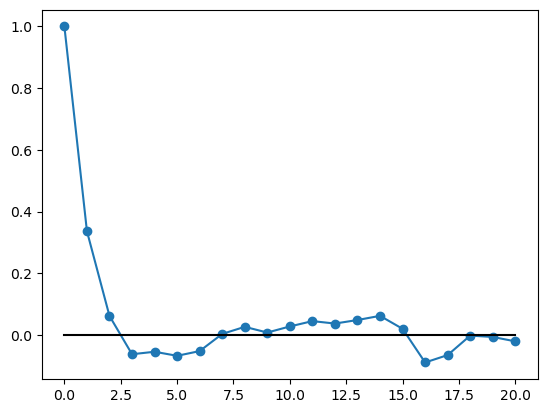

(-0.0024542420827182248, 0.33655226887726675)

In [52]:
YW_AR_1(ar_1)

In [92]:
def OLSE_AR_2(D): #xt=b`zt + wt where zt = (x_{t-1}, x_{t-2}, b =(b1, b2))
    n = len(D)
    X = np.array(D) - np.mean(D)
    Z, xx = [],[]
    for t in range(2, n):
        zt = [X[t-1], X[t-2]]
        Z.append(zt)
        xx.append(X[t])
    Z = np.array(Z)
    xx = np.array(xx) # hat_b =(Z`Z)^{-1}(Z`xx)
    First = np.dot(Z.T, Z) # T=transpose
    Second = np.dot(Z.T, xx)
    F_inv = np.linalg.inv(First)
    olse = np.dot(F_inv, Second)
    phi1, phi2 = olse
    phi0 = np.mean(D)*(1-phi1-phi2)
    return phi0, phi1, phi2

In [93]:
OLSE_AR_2(ar_2)

(1.0657252395766743, 0.6016138140317365, -0.12954494983817472)

# 이 부분부터 강의노트가 틀린 부분이 있음

In [43]:
def YW_AR_2(D): 
    n = len(D)
    X = np.array(D) - np.mean(D)
    rho = ACF(D) # AX=B  ==X=A^{-1}B
    B = np.zeros((2, 1))
    A = np.zeros((2, 2))
    for i in range(2): #i = 0, 1
        B[i][0] = rho[i+1]
        for j in range(2): #j=0,1
            if i >= j:
                A[i][j] = rho[i-j]
            else:
                A[i][j] = rho[j-i]
    A_inv = np.linalg.inv(A)
    phi = np.dot(A_inv, B)
    phi1, phi2 = phi
    phi0 = np.mean(D)*(1-phi1-phi2)
    return phi0, phi1, phi2

In [57]:
def FORE_AR1(D):
    mu = np.mean(D)
    print(mu)
    olse = OLSE_AR_1(D)
    print(olse) #phi0, phi1
    Xt = D[-1] # the last
    Xt1 = mu+olse[1]*(Xt-mu) # one-step forecast
    Xt2 = mu*olse[1]*(Xt1-mu) # two-step forecast
    Xt3 = mu+olse[1]*(Xt2-mu) # three-step forecast
    return Xt1, Xt2, Xt3

In [72]:
def Graph_FORE_AR1(D, ell):
    mu = np.mean(D)
    X = np.array(D) - mu
    olse = OLSE_AR_1(D) #phi0, phi1
    L = []
    Xt = D[-1] # the lst
    for k in range(1, ell+1): #k =1,2,3,....,ell (step forecast)
        fore_k = mu+olse[1]*(Xt-mu)
        L.append(fore_k)
        Xt=fore_k
    plt.plot(L)
    plt.show()
    return L

In [75]:
3/(1-0.6)

7.5

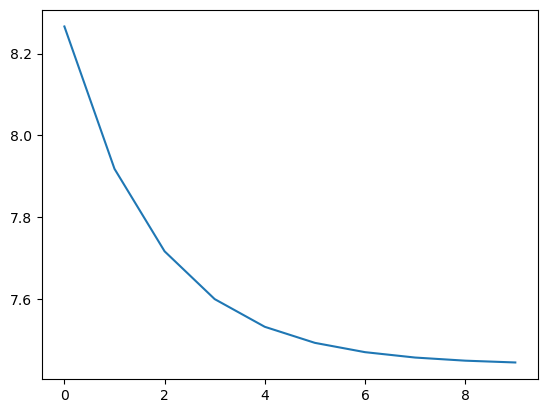

[8.26628990661217,
 7.918454832787191,
 7.716902722028836,
 7.600113886146263,
 7.532440905022492,
 7.493227975639558,
 7.470506147736356,
 7.457340044836443,
 7.449710981439362,
 7.445290340893019]

In [74]:
Graph_FORE_AR1(ar_1, 10)

In [96]:
def ERROR_one_step_forecast_AR1(D, m): #RMSE, MAE 강의노트 오류
    T = len(D)
    n = T-m
    Lr, Lf, Le = [], [], []
    for i in range(m): #i=0,1,...,m-1 총 m개
        INS = D[i:i+n] # of size n, from i, i+1, ....., i+n-1
        Real_one = D[i+n] # one-step real value
        mu = np.mean(INS)
        olse = OLSE_AR_1(INS) #phi0, phi1
        Xt = INS[-1] # the last
        Fore_one = mu+olse[1]*(Xt-mu)
        Lr.append(Real_one)
        Lf.append(Fore_one)
        Le.append(Real_one - Fore_one)
    Le = np.array(Le)
    MAE = np.mean(np.abs(Le))
    RMSE = (np.mean(Le**2))**0.5
    print(MAE, RMSE, '=MAE, RMSE')
    plt.plot(Lr, 'b', label='Real value', marker = 'o')
    plt.plot(Lf, 'r', label='Forecast', marker = '*')
    plt.legend()
    plt.show()
    return Lr, Lf

0.7572394847732491 1.0036716569431785 =MAE, RMSE


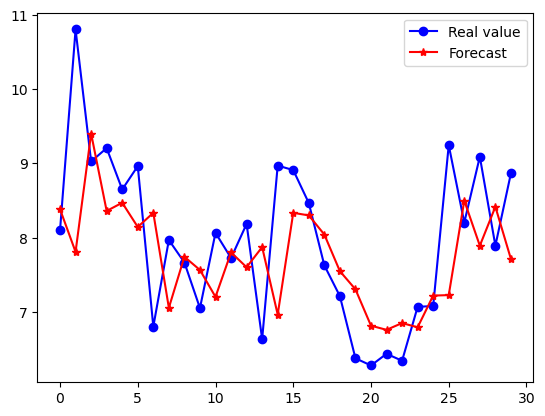

([8.096192264611615,
  10.804923823235189,
  9.02623741846232,
  9.205976614136427,
  8.648741029015914,
  8.963585162326988,
  6.800480963471502,
  7.9672302867506595,
  7.664493893311096,
  7.049916569348203,
  8.063968257731018,
  7.7243983088427015,
  8.184605942139438,
  6.631852677239603,
  8.970577200544794,
  8.910174327810754,
  8.466074577487968,
  7.6257541032074325,
  7.211025752002028,
  6.3736973314804635,
  6.276690814165026,
  6.434116210692921,
  6.340125724895264,
  7.066955144274691,
  7.078069366141114,
  9.246079628840304,
  8.202690578532257,
  9.090223839836057,
  7.891286515783055,
  8.866577535094939],
 [8.382727222154056,
  7.807567540699578,
  9.401640797144609,
  8.35924420241317,
  8.469848774277771,
  8.143227884517893,
  8.334207388045284,
  7.0538479488645285,
  7.741668336005212,
  7.563384704840622,
  7.201102249351189,
  7.800385591922749,
  7.6008794638732216,
  7.872256691699433,
  6.962986518541631,
  8.333750398846856,
  8.299341688868495,
  8.041

In [97]:
ERROR_one_step_forecast_AR1(ar_1, 30)